In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
import collections

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Функции для расчета энтропии и прироста информации (5 баллов)

Пример для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [2]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

Дальше пусть шарики разбиваются на 2 группы

In [3]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

**Реализуйте функцию для расчета энтропии Шеннона.**

In [4]:
def entropy(a_list):
    data = np.array(a_list)
    probs = np.unique(data, return_counts=True)[1] / len(data)
    return -(probs *  np.log2(probs)).sum()

Проверка

In [5]:
print("Entropy for balls %.3f"%(entropy(balls))) # 9 синих и 11 желтых
print("Entropy for balls_left %.3f"%(entropy(balls_left))) # 8 синих и 5 желтых
print("Entropy for balls_right %.3f"%(entropy(balls_right))) # 1 синий и 6 желтых
print("Entropy for dice %.3f"%(entropy([1,2,3,4,5,6]))) # энтропия игральной кости с несмещенным центром тяжести

Entropy for balls 0.993
Entropy for balls_left 0.961
Entropy for balls_right 0.592
Entropy for dice 2.585


Чему равна энтропия состояния, заданного списком `balls_left`?

Ответ: 0.96

Чему равна энтропия игральной кости с несмещенным центром тяжести?

Ответ: 2.58

In [6]:
# расчет прироста информации

def information_gain(root, left, right):
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    sum_entrop = len(left) / len(root) * entropy(left) + len(right) / len(root) * entropy(right)
    return entropy(root) - sum_entrop

Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [7]:
print("Information gain is %.3f"%(information_gain(balls, balls_left, balls_right)))

Information gain is 0.161


In [103]:
def best_feature_to_split(X, y, verbose=0):
    ''' Выводит прирост информации при разбиении по каждому признаку'''
    max_gain = float('-inf')
    best_feature = None
    best_divide = None

    for feature in X:
        if verbose:
            print("Feature ", feature, ':')

        feature_uniq_values = np.unique(np.array(X[feature]))
        for i in range(len(feature_uniq_values)):
            value = feature_uniq_values[i]
            left_part = [y[j] for j in range(len(y)) if X[feature][j] <= value]
            right_part = [y[j] for j in range(len(y)) if X[feature][j] > value]
            gain = information_gain(y, left_part, right_part)
            if gain > max_gain:
                max_gain = gain
                best_feature = feature
                best_divide = value
            if verbose:
                print("\tFor value %s information gain %.2f"%(str(value), gain))
    
    return {"feature_name": best_feature, "splitting_value": best_divide}

In [104]:
## Test best_feature_to_split
test_balls = [0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
train_balls = pd.DataFrame(range(len(test_balls)), columns=["Numbers"])
print(best_feature_to_split(train_balls, test_balls, verbose=1))

Feature  Numbers :
	For value 0 information gain 0.04
	For value 1 information gain 0.00
	For value 2 information gain 0.02
	For value 3 information gain 0.07
	For value 4 information gain 0.12
	For value 5 information gain 0.06
	For value 6 information gain 0.02
	For value 7 information gain 0.00
	For value 8 information gain 0.00
	For value 9 information gain 0.01
	For value 10 information gain 0.03
	For value 11 information gain 0.08
	For value 12 information gain 0.16
	For value 13 information gain 0.11
	For value 14 information gain 0.06
	For value 15 information gain 0.03
	For value 16 information gain 0.01
	For value 17 information gain 0.00
	For value 18 information gain 0.06
	For value 19 information gain 0.00
{'feature_name': 'Numbers', 'splitting_value': 12}


In [105]:
## Test on multy feature
train_balls = np.array([range(len(test_balls)), [1, 2] * (len(test_balls)//2)]).T
train_balls = pd.DataFrame(train_balls, 
                            columns=["Numbers", "Useless feature"])
print(best_feature_to_split(train_balls, test_balls, verbose=1))

Feature  Numbers :
	For value 0 information gain 0.04
	For value 1 information gain 0.00
	For value 2 information gain 0.02
	For value 3 information gain 0.07
	For value 4 information gain 0.12
	For value 5 information gain 0.06
	For value 6 information gain 0.02
	For value 7 information gain 0.00
	For value 8 information gain 0.00
	For value 9 information gain 0.01
	For value 10 information gain 0.03
	For value 11 information gain 0.08
	For value 12 information gain 0.16
	For value 13 information gain 0.11
	For value 14 information gain 0.06
	For value 15 information gain 0.03
	For value 16 information gain 0.01
	For value 17 information gain 0.00
	For value 18 information gain 0.06
	For value 19 information gain 0.00
Feature  Useless feature :
	For value 1 information gain 0.01
	For value 2 information gain 0.00
{'feature_name': 'Numbers', 'splitting_value': 12}


## 2. Деревья решений на наборе данных Adult (10 баллов)

**Описание набора:**

https://archive.ics.uci.edu/ml/datasets/adult (для ознакомления, а сами данные adult_train, adult_test располагаются в папке datasets на нашем GitHub):

Классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более 50 000 \$ в год.

Описание признаков: 

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак  

**Считываем обучающую и тестовую выборки.**

In [9]:
data_train = pd.read_csv('../datasets/adult_train.csv', sep=';')
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [10]:
data_test = pd.read_csv('../datasets/adult_test.csv', sep=';') 
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [11]:
# необходимо убрать строки с неправильными метками в тестовой выборке
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# перекодируем target в числовое поле
data_train.replace(' <=50K', 0, inplace=True)
data_train.replace(' >50K', 1, inplace=True)

data_test.replace(' <=50K.', 0, inplace=True)
data_test.replace(' >50K.', 1, inplace=True)

**Первичный анализ данных.**

In [12]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

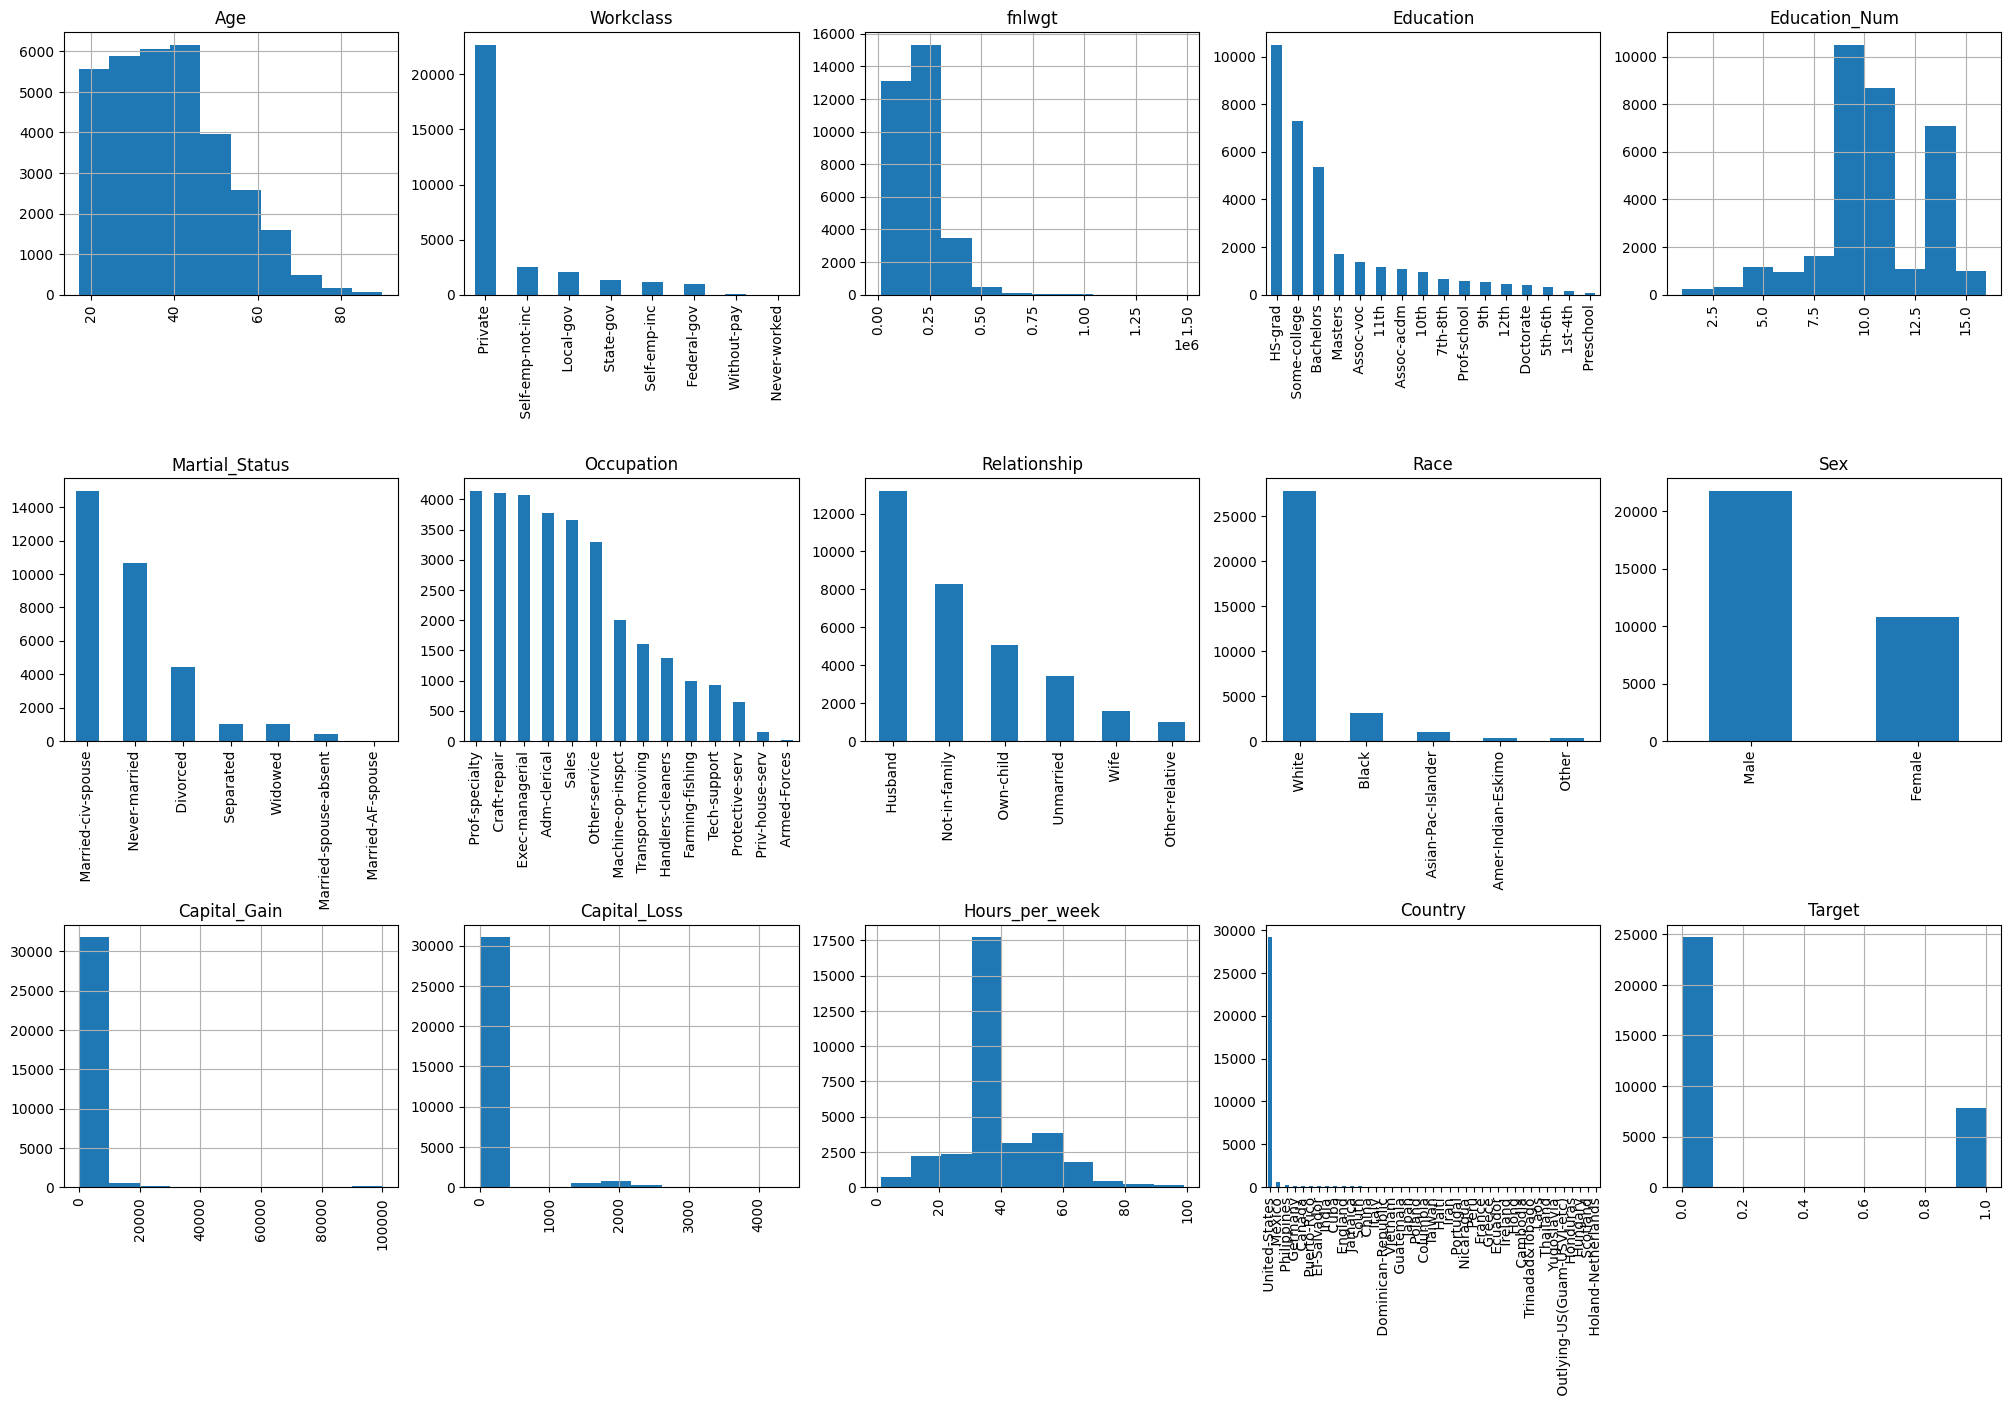

In [14]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object_:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Проверяем типы данных**

In [15]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [16]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

In [17]:
data_test['Age'] = data_test['Age'].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [18]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением**

In [19]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [20]:
# заполним пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

**Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.**

In [21]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [22]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [23]:
data_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...
Country_ Thailand,16281.0,0.000737,0.027140,0.0,0.0,0.0,0.0,1.0
Country_ Trinadad&Tobago,16281.0,0.000491,0.022162,0.0,0.0,0.0,0.0,1.0
Country_ United-States,16281.0,0.900559,0.299262,0.0,1.0,1.0,1.0,1.0
Country_ Vietnam,16281.0,0.001167,0.034143,0.0,0.0,0.0,0.0,1.0


In [24]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [25]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.**

In [26]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [27]:
set(data_train.columns) - set(data_test.columns)

set()

In [28]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


In [30]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

In [31]:
# Put columns name in same order for removing DecisionTreeClassifier warnings
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

## 2.1. Дерево решений без настройки параметров (5 баллов)

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.**

In [32]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [33]:
tree_predictions = tree.predict(X_test)

In [34]:
print("Accuracy of Decision Tree %.2f"%(accuracy_score(y_test, tree_predictions)))

Accuracy of Decision Tree 0.84


Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

Ответ: 0.84

## 2.2. Дерево решений с настройкой параметров (5 баллов)

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`.**

In [35]:
tree_params = {'max_depth': range(2,11)}

clf = DecisionTreeClassifier(random_state=17)
locally_best_tree = GridSearchCV(clf, tree_params, n_jobs=-1, verbose=2, cv=20)                      

locally_best_tree.fit(X_train, y_train)

Fitting 20 folds for each of 9 candidates, totalling 180 fits
[CV] END ........................................max_depth=2; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ......................................

GridSearchCV(cv=20, estimator=DecisionTreeClassifier(random_state=17),
             n_jobs=-1, param_grid={'max_depth': range(2, 11)}, verbose=2)

In [36]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score %.2f"%(locally_best_tree.best_score_))

Best params: {'max_depth': 10}
Best cross validaton score 0.86


**Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.**

In [37]:
tuned_tree = locally_best_tree.best_estimator_
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
print("Accuracy of Decision Tree with tuning %.2f"%(accuracy_score(y_test, tuned_tree_predictions)))

Accuracy of Decision Tree with tuning 0.86


Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

Ответ: 0.86

# 3. Логистическая регрессия в задаче кредитного скоринга (15 баллов)



#### Данные представлены следующим образом (credit_scoring_sample из наших datasets на GitHub):

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [38]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [39]:
## Считываем данные 

data = pd.read_csv("../datasets/credit_scoring_sample.csv", sep=";") # прописать путь в ависимости от того, где выполняете работу
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [40]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

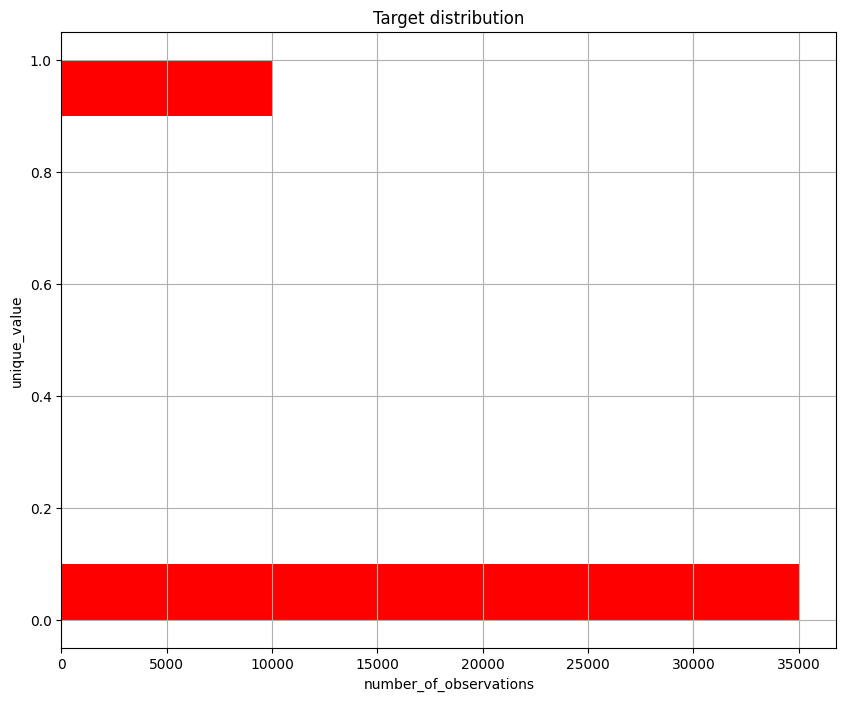

In [41]:
## Посмотрим на распределение классов в зависимой переменной

ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [42]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [43]:
def delete_nan(data, inplace=False):
    if inplace:
        table = data
    else:
        table = data.copy()
        
    categorical_columns = [c for c in table.columns 
                             if table[c].dtype.name == 'object']
    numerical_columns = [c for c in table.columns 
                            if table[c].dtype.name != 'object']

    for c in categorical_columns:
        table[c] = table[c].fillna(table[c].mode())
    
    for c in numerical_columns:
        table[c] = table[c].fillna(table[c].median())
    
    return table
    

In [44]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)

## Check if delete_nan works
data.isnull().values.any(), table.isnull().values.any()

(True, False)

In [45]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

In [46]:
## Normalization of X and y
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()
normalizer.fit(X)
X_normalized = normalizer.transform(X)

Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе значение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Используем модуль LogisticRegression для построения логистической регрессии.
# Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
# Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced", max_iter=1000)

# Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
# Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
# и будет хорошо предсказывать значения таргета, с другой.
# Остальные параметры оставляем по умолчанию.
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

# Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
# значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [48]:
# Можно ли считать лучшую модель устойчивой? 
# (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) 
# Cохраните точность лучшей модели, она вам приходится для следующих заданий

logit_cv = GridSearchCV(lr, parameters, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=1)
logit_cv.fit(X_normalized, y)
logit_cv_roc_best = logit_cv.best_score_
logit_cv_estimator = logit_cv.best_estimator_
print("Best params:", logit_cv.best_params_)
print("Best cross validaton score %.2f"%(logit_cv.best_score_))
print("Standart deviation for best model %.4f"%(logit_cv.cv_results_['std_test_score'][logit_cv.best_index_]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'C': 10}
Best cross validaton score 0.79
Standart deviation for best model 0.0032


Стандартное отклонение оценок в лучшей модели 0.0032 поэтому модуль можно считать устойчивой.

## 3.1 Определение влияния признаков (5 баллов) 

Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [49]:
def draw_importances(importances, features_names):
    indices = np.argsort(importances)[::-1]
    features_len = len(features_names)
    for f in range(features_len):
        print(
            "%d. %s %f "
            % (f + 1, 
                independent_columns_names[indices[f]],
                importances[indices[f]])
        )

    plt.figure(figsize=(15, 5))
    plt.title(u"Важность фич")
    bars = plt.bar(
        range(features_len),
        importances[indices[:features_len]],
        color=([str(i / float(features_len + 1)) for i in range(features_len)]),
        align="center",
    )
    plt.xticks(range(features_len), range(1, features_len + 1))
    plt.xlim([-1, features_len])
    plt.legend(bars, [u"".join(independent_columns_names[i]) for i in indices])

Feature with max weight is NumberOfTime30-59DaysPastDueNotWorse
1. NumberOfTime30-59DaysPastDueNotWorse 3.277332 
2. NumberOfTimes90DaysLate 3.065582 
3. age 0.436496 
4. MonthlyIncome 0.203966 
5. NumberOfDependents 0.085266 
6. NumberOfTime60-89DaysPastDueNotWorse 0.076360 
7. DebtRatio 0.042338 


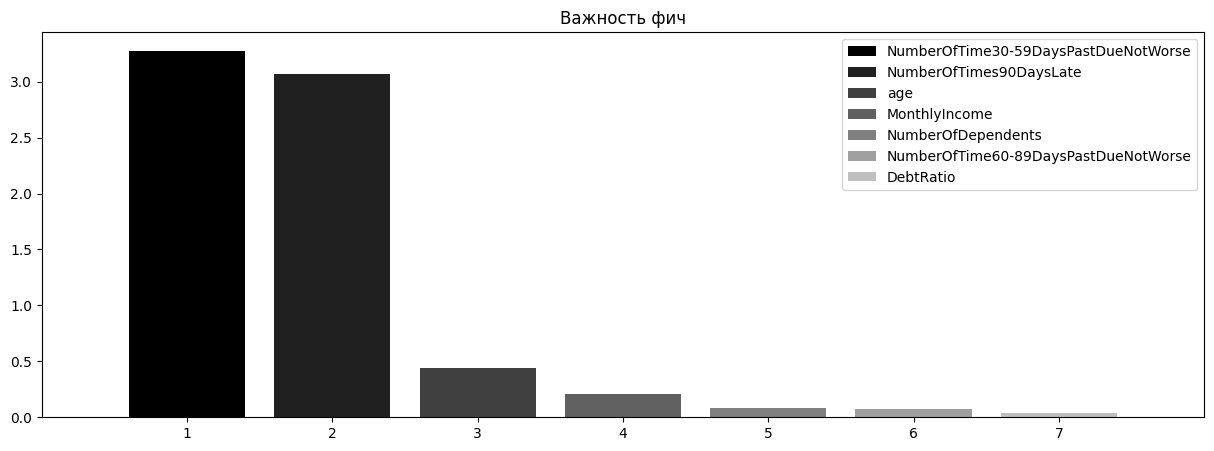

In [50]:
max_weight_feature = np.argmax(np.abs(logit_cv_estimator.coef_[0]))
print("Feature with max weight is", independent_columns_names[max_weight_feature])
draw_importances(np.abs(logit_cv_estimator.coef_[0]), independent_columns_names)

In [51]:
# Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией softmax)
from scipy.special import softmax

debt_index = np.where(np.array(independent_columns_names) == 'DebtRatio')
print("Influence of DebtRatio %.2f"%(softmax(logit_cv_estimator.coef_[0])[debt_index][0] * 100) + "%")

Influence of DebtRatio 1.82%


# 4. Случайный лес (5 баллов) 

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

## Делаем опять же k-fold валидацию. 

In [53]:
# Насколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

rf_cv = GridSearchCV(rf, parameters, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=1)
rf_cv.fit(X_normalized, y)
best_forest = rf_cv.best_estimator_
print("Best params:", rf_cv.best_params_)
print("Best cross validaton score %.2f"%(rf_cv.best_score_))
print("Random forest have score greater for %.2f"%(rf_cv.best_score_ - logit_cv_roc_best))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 9}
Best cross validaton score 0.84
Random forest have score greater for 0.05


Feature with min weight is NumberOfDependents
1. NumberOfTimes90DaysLate 0.314289 
2. NumberOfTime30-59DaysPastDueNotWorse 0.296215 
3. NumberOfTime60-89DaysPastDueNotWorse 0.129030 
4. age 0.100195 
5. DebtRatio 0.087578 
6. MonthlyIncome 0.060962 
7. NumberOfDependents 0.011730 


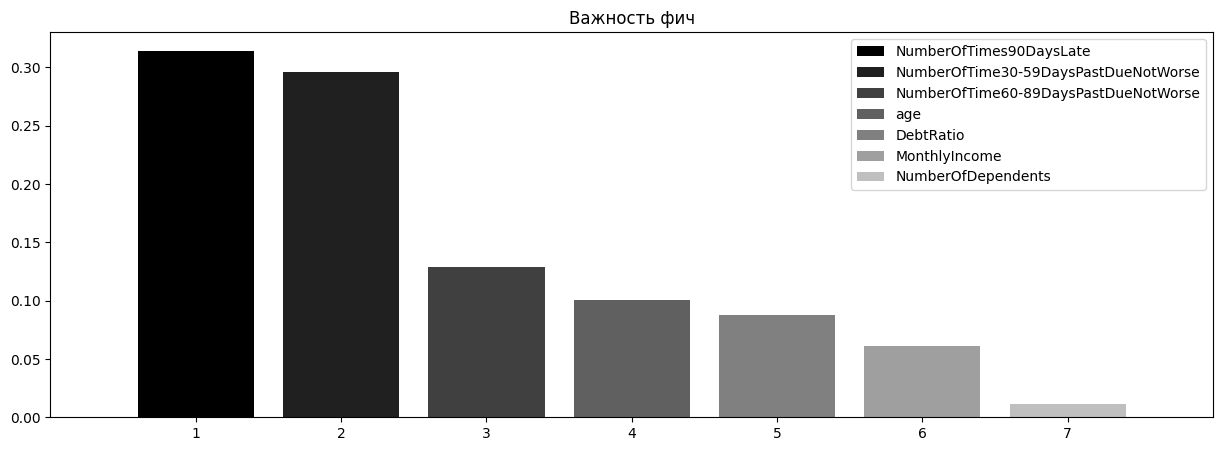

In [54]:
# Какой признак имеет наименьшее влияние?
min_weight_feature = np.argmin(best_forest.feature_importances_)
print("Feature with min weight is", independent_columns_names[min_weight_feature])
draw_importances(best_forest.feature_importances_, independent_columns_names)